# various access sizes, cache cleared

## <font color="orange"> Process for experiments </font>

1. Cube sizes from $2^6$ to $2^{30}$, starting from biggest. Expressed as Cube Root

2. Read 32GB of data from different variable to make sure cache is clear

3. Pick a random starting chunk

4. Read a cube from this starting point (see #1). Minimizes nr. chunks accessed

In [3]:
import zarr # Check version
import numpy as np
from matplotlib import pyplot as plt
from random import randint

zarr.__version__

'2.13.2'

In [4]:
chunk_sizes = [ 2**i for i in range(6,30)]

In [5]:
cube_root_size = [int(x ** (1. / 3)) for x in chunk_sizes]
cube_root_size[:5]

[3, 5, 6, 7, 10]

In [6]:
ncar_data = zarr.open("sciserver-experimental/ariel/tests")
ncar_data.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,6
No. arrays,6
No. groups,0
Arrays,"e, p, t, u, v, w"


# Compressed
## Cold-cache access all chunk sizes 2^6 - 2^30

I think outliers (too fast) in 2nd run are by chance if random starting point is the same for both?

In [7]:
ncar_uncompressed = zarr.open("ncar_zarr_uncompressed")
ncar_uncompressed.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,3
No. groups,0
Arrays,"e, t, w"


# Cold - Minimizing nr. chunks hit

<font color="orange">In above, random initialization means the number of chunks accessed at each run is non-deterministic</font>

Below, I run experiments starting always from the first point (0,0,0) in a randomly chosen chunk

# Compressed

In [2]:
chunk_size = 256

In [52]:
ncar_data['e'].info

Name,/e
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,13989514907 (13.0G)


In [1]:
# Energy field
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
#     _ = ncar_uncompressed['w'][0:1024,0:1024,0:1024]
    _ = ncar_uncompressed['t'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    
    random_start_point = chunk_size * randint(0, 4)
    %timeit -o -n 1 -r 1 ncar_data['e'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

NameError: name 'cube_root_size' is not defined

In [227]:
# MCU - Minimum chunk uncompressed. See above what Minimum chunk means
# mcc_e = [37900, 13900, 2480, 1850, 1450, 303, 297, 187, 142, 192, 146, 131, 215, 147, 145, 155, 224, 167, 206, 144, 117, 138, 157, 142]

# 2048^3 used in-between %timeit to clear cache. Should be more accurate than 1024^3. Former is 32GB. Latter 4GB
mcc_e = [[27600, 7370, 5980, 1650, 1550, 415, 422, 388, 129, 484, 309, 127, 433, 377, 487, 315, 454, 332, 387, 114, 435, 335, 311, 201]
         , [20100, 6200, 3200, 1990, 1090, 754, 215, 361, 382, 416, 351, 144, 84.5, 305, 71.5, 85.6, 498, 128, 329, 409, 600, 276, 287, 192]]
# []

# mcc_e.reverse()
[i.reverse() for i in mcc_e]
mcc_e = np.array(mcc_e)

In [56]:
ncar_data['w'].info

Name,/w
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,27329309819 (25.5G)


In [ ]:
# w velocity field
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
#     _ = ncar_uncompressed['w'][0:1024,0:1024,0:1024]
    _ = ncar_uncompressed['e'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    
    random_start_point = chunk_size * randint(0, 4)
    %timeit -o -n 1 -r 1 ncar_data['w'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

In [228]:
# Results with 1024^3 (4GB) accessed between timeits for cache clearing
# mcc_w = [44000, 11900, 4250, 3790, 2780, 342, 273, 218, 188, 182, 223, 148, 167, 154, 160, 145, 149, 170, 152, 216, 164, 139, 179, 164]

# Results with 2048^3 (32GB) accessed between timeits for cache clearing
mcc_w = [[56900, 21500, 3850, 6060, 3090, 600, 586, 420, 383, 499, 370, 382, 389, 470, 339, 443, 366, 385, 351, 500, 481, 298, 330, 335]
         , [35700, 15300, 3580, 4420, 2860, 644, 581, 480, 497, 458, 626, 499, 462, 306, 405, 358, 452, 489, 434, 369, 598, 333, 473, 686]]
#         ,[]]

# mcc_w.reverse()
[i.reverse() for i in mcc_w]
mcc_w = np.array(mcc_w)

In [57]:
ncar_data['t'].info

Name,/t
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,19025554335 (17.7G)


In [ ]:
# temperature field
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
# for i in range(6,-1,-1):
#     _ = ncar_uncompressed['w'][0:1024,0:1024,0:1024]
    _ = ncar_uncompressed['w'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    
    random_start_point = chunk_size * randint(0, 4)
    %timeit -o -n 1 -r 1 ncar_data['t'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

In [229]:
# Results with 1024^3 (4GB) accessed between timeits for cache clearing
# mcc_t = [30300, 7740, 2550, 1850, 1630, 307, 263, 164, 161, 151, 142, 157, 139, 144, 139, 131, 202, 137, 159, 140, 194, 154, 154, 152]

# Results with 2048^3 (32GB) accessed between timeits for cache clearing
mcc_t = [[41600, 16200, 4700, 3230, 2720, 575, 429, 249, 337, 370, 340, 294, 416, 334, 255, 224, 184, 290, 167, 171, 315, 630, 235, 283]
         , [26600, 10900, 6080, 2200, 2300, 559, 475, 250, 273, 343, 272, 291, 285, 159, 298, 302, 233, 294, 321, 282, 261, 286, 362, 273]]
#          , [84000, 13400, 7080, 2940, 2140, 489, 420, 422, 433, 321, 387, 333, 236, 411, 349, 387, 262, 385]]
# []

# mcc_t.reverse()
[i.reverse() for i in mcc_t]
mcc_t = np.array(mcc_t)

## Uncompressed

In [218]:
np.array(cube_root_size)

array([  3,   5,   6,   7,  10,  12,  15,  20,  25,  31,  40,  50,  63,
        80, 101, 127, 161, 203, 255, 322, 406, 511, 645, 812])

In [61]:
ncar_uncompressed['e'].info

Name,/e
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,34359738622 (32.0G)


In [ ]:
# Energy field
for i in range(4,-1,-1):
# for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
#     _ = ncar_uncompressed['w'][0:1024,0:1024,0:1024]
    _ = ncar_data['t'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    
    random_start_point = chunk_size * randint(0, 4)
    %timeit -o -n 1 -r 1 ncar_uncompressed['e'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

In [220]:
# MCC - min nr. chunks accessed per nr. points. MCC = min chunk compressed
# Results with 1024^3 (4GB) accessed between timeits for cache clearing
# mcu_e = [36400, 8070, 2660, 1880, 1510, 761, 300, 186, 241, 173, 162, 164, 154, 385, 166, 189, 200, 163, 146, 210, 175, 314, 180, 167]

# Results with 2048^3 (32GB) accessed between timeits for cache clearing
mcu_e = [[27300, 12800, 4250, 3580, 2490, 1150, 449, 399, 483, 344, 539, 388, 309, 288, 348, 325, 1460, 354, 379, 337, 355, 399, 289, 475],
         [26700, 14800, 3730, 2590, 1870, 588, 465, 317, 324, 360, 311, 346, 215, 327, 327, 499, 319, 328, 337, 211, 403, 358, 348, 341]
        ,[38900, 15000, 4480, 3180, 2900, 515, 612, 298, 294, 487, 556, 318, 534, 460, 265, 487, 410, 240, 311, 410, 370, 456, 331, 388]]
#         , [38300, 11100, 4180, 3180, 3430, 649, 381, 400, 420, 528, 333, 340, 422, 438, 448, 401, 428, 365, 382, 376]]


# mcu_e.reverse()
[i.reverse() for i in mcu_e]
mcu_e = np.array(mcu_e)

In [62]:
ncar_uncompressed['w'].info

Name,/w
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,34359738622 (32.0G)


In [217]:
# w velocity field
i = 0
# for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
#     _ = ncar_uncompressed['w'][0:1024,0:1024,0:1024]
#     _ = ncar_data['e'][0:2048,0:2048,0:2048]
print(cube_root_size[i])

random_start_point = chunk_size * randint(0, 4)
%timeit -o -n 1 -r 1 ncar_uncompressed['w'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

3
502 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 502 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [226]:
# Results with 1024^3 (4GB) accessed between timeits for cache clearing
# Outlier at cube_root=127
# mcu_w = [30400, 13700, 4220, 1930, 1450, 350, 271, 147, 566, 145, 157, 160, 150, 136, 188, 161, 136, 138, 157, 151, 159, 120, 156, 119]

# Results with 2048^3 (32GB) accessed between timeits for cache clearing
mcu_w = [[35000, 12400, 6170, 2870, 2770, 682, 490, 586, 384, 325, 404, 430, 324, 341, 321, 406, 6710, 397, 339, 378, 575, 355, 311, 366],
         [32300, 14700, 4000, 3040, 2860, 538, 441, 327, 280, 252, 363, 405, 348, 293, 364, 296, 424, 302, 227, 435, 386, 259, 267, 262]
         , [38200, 12500, 4530, 4870, 2410, 606, 610, 449, 452, 401, 306, 275, 295, 496, 452, 521, 310, 306, 268, 326, 558, 453, 508, 502]]
#          , [37900, 13700, 4330, 5040, 2920, 587, 555, 354, 336, 280, 512, 362, 328, 401, 293, 310, 418, 328, 393, 347, 534, 355, 512]]

# mcu_w.reverse()
[i.reverse() for i in mcu_w]
mcu_w = np.array(mcu_w)

In [63]:
ncar_uncompressed['t'].info

Name,/t
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,34359738622 (32.0G)


In [209]:
# Temperature field
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
#     _ = ncar_uncompressed['w'][0:1024,0:1024,0:1024]
    _ = ncar_data['e'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    
    random_start_point = chunk_size * randint(0, 4)
    %timeit -o -n 1 -r 1 ncar_uncompressed['t'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

812
34.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
645
14.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
511
5.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
406
3.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
322
3.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
255
647 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
203
665 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
161
354 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
127
401 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
101
687 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
80
443 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
63
459 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
50
418 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
40
399 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
31
268 ms ± 0 ns per loop (mean ± std. dev. of 1 run

<font color="orange">There's still some caching going on. Accessing single point not in a loop is ~500-600ms. TODO Randal what to do about this?</font>

In [230]:
# Results with 1024^3 (4GB) accessed between timeits for cache clearing
# 1st is >768 => need to read 4 chunks
# 2nd =645 (>512) so 3 chunks. Then 2, and so on
# Outlier at cube size=50. Why?
# mcu_t = [21900, 6560, 2370, 1800, 1410, 320, 204, 141, 130, 150, 120, 173, 422, 173, 132, 155, 132, 143, 124, 131, 127, 130, 151, 127]

# Results with 2048^3 (32GB) accessed between timeits for cache clearing
mcu_t = [[44200, 15100, 4680, 2780, 2260, 454, 413, 419, 259, 213, 308, 319, 352, 241, 313, 383, 236, 410, 336, 277, 258, 361, 311, 291],
         [35700, 16000, 3310, 2510, 4180, 479, 388, 454, 380, 312, 304, 421, 345, 250, 216, 245, 420, 264, 302, 409, 272, 289, 257, 504]
        , [34900, 14700, 5670, 3260, 3290, 647, 665, 354, 401, 687, 443, 459, 418, 399, 268, 424, 416, 289, 246, 257, 273, 300, 435, 341]]

# mcu_t = [i.reverse() for i in mcu_t]
[i.reverse() for i in mcu_t]
mcu_t = np.array(mcu_t)
# mcu_t

### 2048 times Cold PolyReg

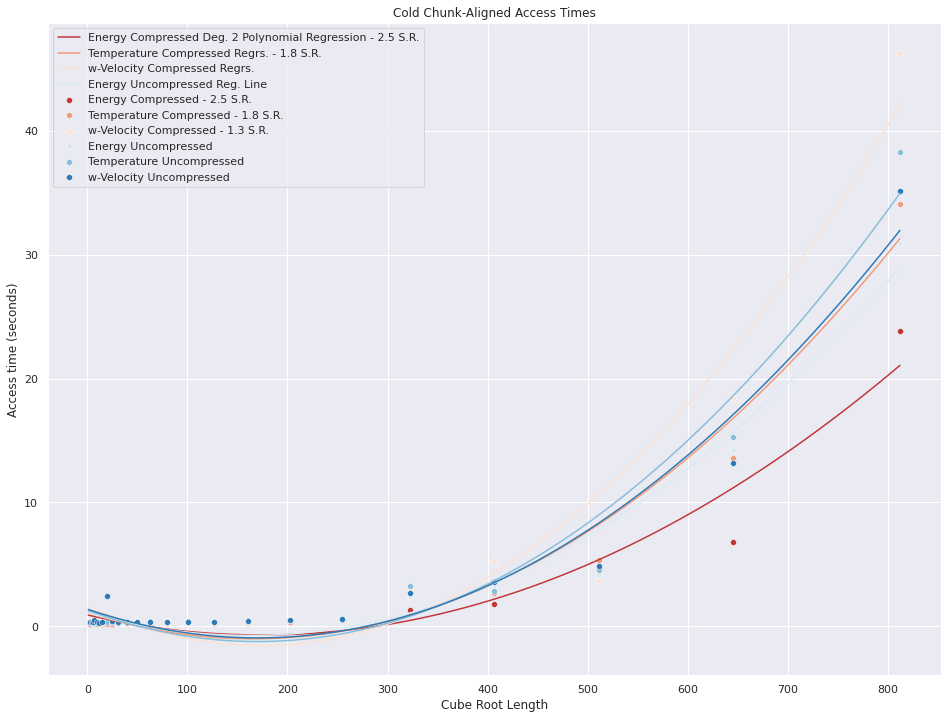

In [233]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})

# Energy compressed
var = np.mean(mcc_e, axis=0) / 1000


# Diverging Palettes - https://www.codecademy.com/article/seaborn-design-ii
sns.set_palette("RdBu")

ax = sns.scatterplot(x=cube_root_size, y=var, label="Energy Compressed - 2.5 S.R.").set(xlabel='Cube Root Length', ylabel='Access time (seconds)')
#ax.set(xlabel='Cube Root Length', ylabel='Access time (ms)')

# https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot
mymodel = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline, mymodel(myline), label="Energy Compressed Deg. 2 Polynomial Regression - 2.5 S.R.")#, color="orange")


# Temperature compressed
var = np.mean(mcc_t, axis=0) / 1000

ax = sns.scatterplot(x=cube_root_size, y=var, label="Temperature Compressed - 1.8 S.R.")

mymodel_t = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_t = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_t, mymodel_t(myline_t), label="Temperature Compressed Regrs. - 1.8 S.R.")



# w-velocity compressed
var = np.mean(mcc_w, axis=0) / 1000

ax = sns.scatterplot(x=cube_root_size, y=var, label="w-Velocity Compressed - 1.3 S.R.")

mymodel_w = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_w = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_w, mymodel_w(myline_w), label="w-Velocity Compressed Regrs.")


# sns.set_palette("dark") # This has no effect for some reason


# Energy Uncompressed
var = np.mean(mcu_e, axis=0) / 1000
ax = sns.scatterplot(x=cube_root_size, y=var, label="Energy Uncompressed", palette=["red"])
#ax.set(xlabel='Cube Root Length', ylabel='Access time (ms)')

mymodel = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline, mymodel(myline), label="Energy Uncompressed Reg. Line")#, color="orange")


# Temperature Uncompressed
var = np.mean(mcu_t, axis=0) / 1000
ax = sns.scatterplot(x=cube_root_size, y=var, label="Temperature Uncompressed")

mymodel_t = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_t = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_t, mymodel_t(myline_t))


# w-velocity Uncompressed
var = np.mean(mcu_w, axis=0) / 1000
ax = sns.scatterplot(x=cube_root_size, y=var, label="w-Velocity Uncompressed", palette=['dark'])

mymodel_w = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_w = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_w, mymodel_w(myline_w))


plt.title("Cold Chunk-Aligned Access Times")
plt.show()

### 2048 with confidence intervals

In [112]:
import pandas as pd

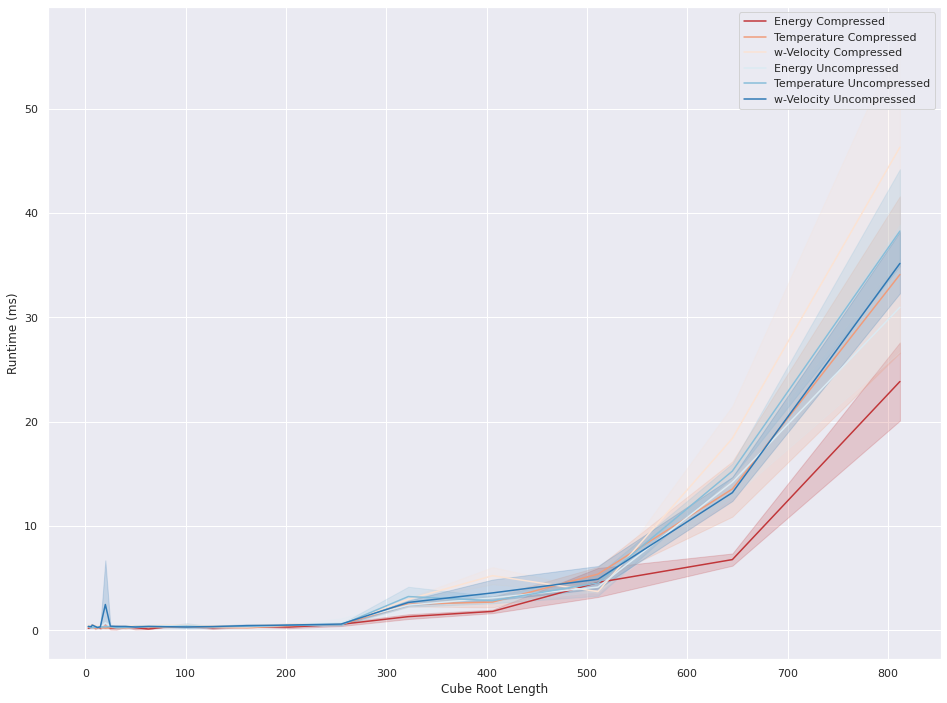

In [239]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})

# Diverging Palettes - https://www.codecademy.com/article/seaborn-design-ii
sns.set_palette("RdBu")


# Energy compressed
var = np.array(mcc_e) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Energy Compressed");


# Temperature compressed
var = np.array(mcc_t) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Temperature Compressed");


# w-Velocity compressed
var = np.array(mcc_w) / 1000


a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="w-Velocity Compressed");


# Uncompressed

# Energy
var = np.array(mcu_e) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Energy Uncompressed");


# Temperature
var = np.array(mcu_t) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Temperature Uncompressed");


# w-Velocity
var = np.array(mcu_w) / 1000


a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="w-Velocity Uncompressed");

Plotting these all together looks horrible

### Plotting Each Variable Above Separately

#### Energy

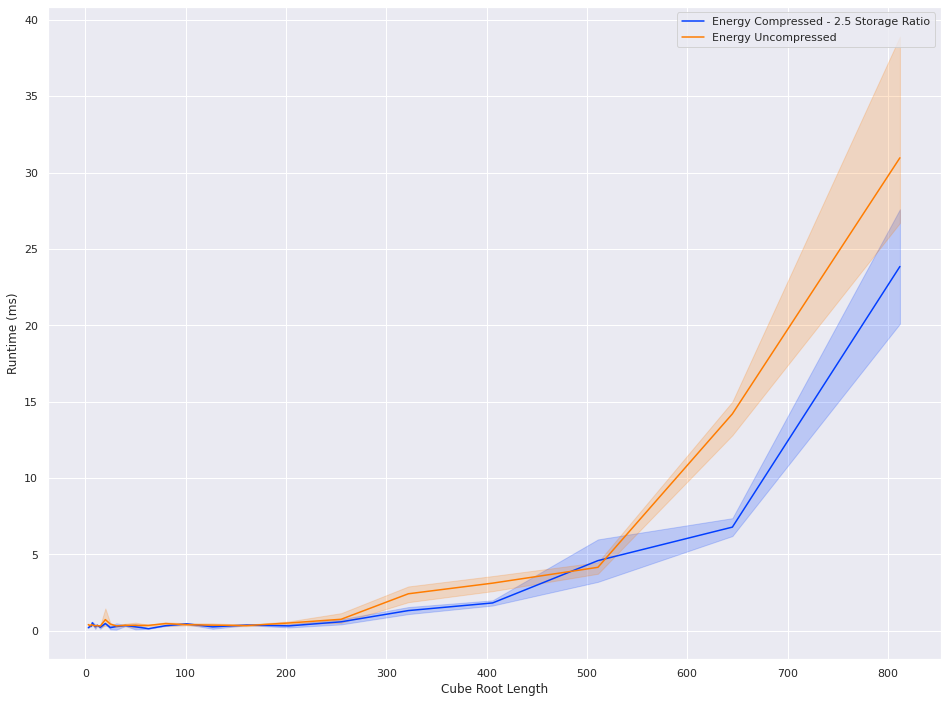

In [247]:
sns.set_palette("bright")

# Energy compressed
var = np.array(mcc_e) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Energy Compressed - 2.5 Storage Ratio");


# Energy Uncompressed
var = np.array(mcu_e) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Energy Uncompressed");

#### Temperature

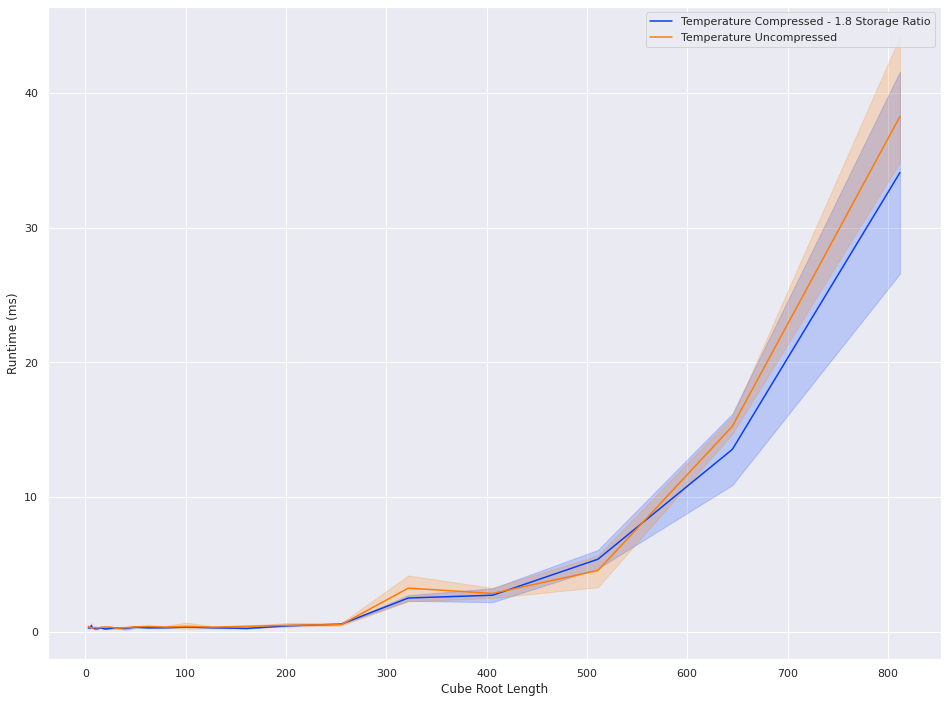

In [248]:
sns.set_palette("bright")

# compressed
var = np.array(mcc_t) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Temperature Compressed - 1.8 Storage Ratio");


# Uncompressed
var = np.array(mcu_t) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Temperature Uncompressed");

#### W-Velocity

In [164]:
np.array(mcc_w).shape

(2, 24)

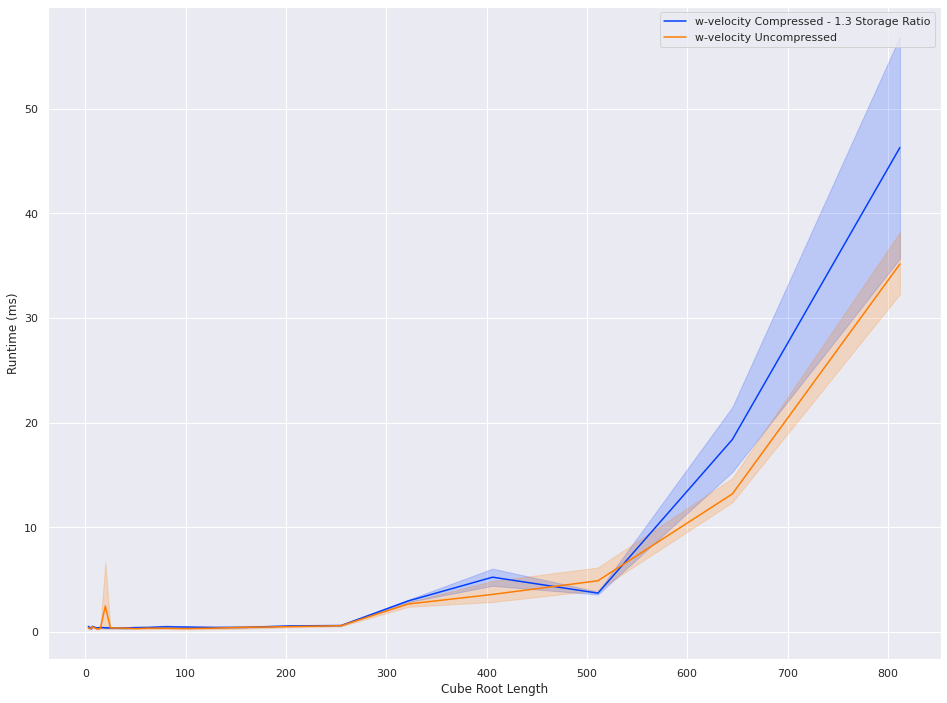

In [249]:
sns.set_palette("bright")

# compressed
var = np.array(mcc_w) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="w-velocity Compressed - 1.3 Storage Ratio");


# Uncompressed
var = np.array(mcu_w) / 1000

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, len(var)), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="w-velocity Uncompressed");

### 1024 cache "cooler"

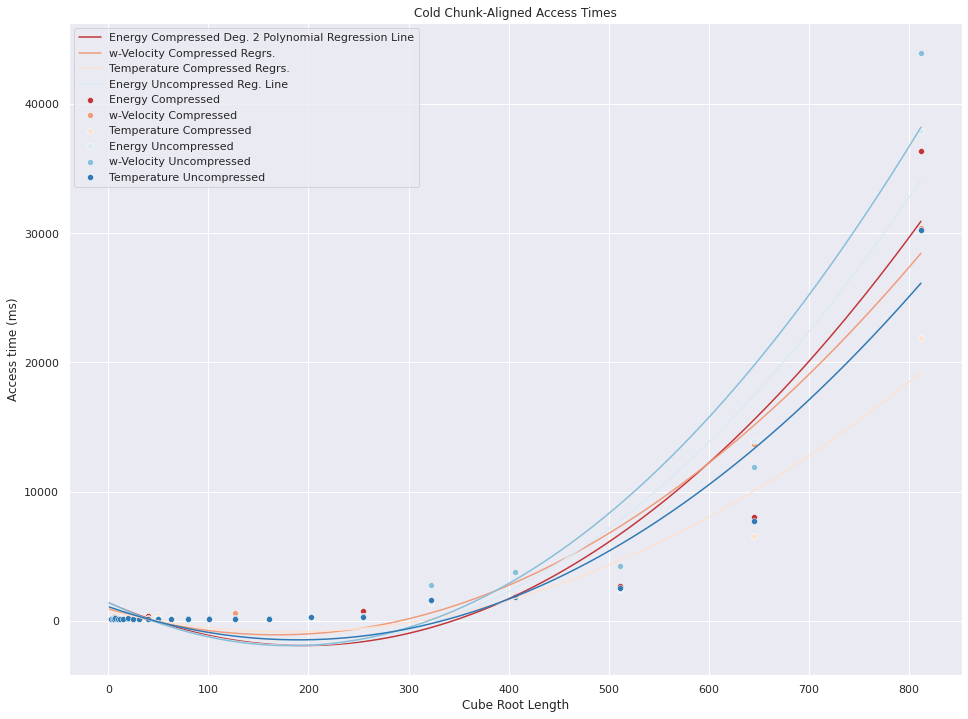

In [141]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})

# Energy compressed
var = mcc_e


# Diverging Palettes - https://www.codecademy.com/article/seaborn-design-ii
sns.set_palette("RdBu")

ax = sns.scatterplot(x=cube_root_size, y=var, label="Energy Compressed").set(xlabel='Cube Root Length', ylabel='Access time (ms)')
#ax.set(xlabel='Cube Root Length', ylabel='Access time (ms)')

# https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot
mymodel = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline, mymodel(myline), label="Energy Compressed Deg. 2 Polynomial Regression Line")#, color="orange")

# w-velocity compressed
var = mcc_w

ax = sns.scatterplot(x=cube_root_size, y=var, label="w-Velocity Compressed")

mymodel_w = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_w = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_w, mymodel_w(myline_w), label="w-Velocity Compressed Regrs.")


# Temperature compressed
var = mcc_t

ax = sns.scatterplot(x=cube_root_size, y=var, label="Temperature Compressed")

mymodel_t = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_t = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_t, mymodel_t(myline_t), label="Temperature Compressed Regrs.")


# sns.set_palette("dark") # This has no effect for some reason


# Energy Uncompressed
var = mcu_e
ax = sns.scatterplot(x=cube_root_size, y=var, label="Energy Uncompressed", palette=["red"])
#ax.set(xlabel='Cube Root Length', ylabel='Access time (ms)')

mymodel = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline, mymodel(myline), label="Energy Uncompressed Reg. Line")#, color="orange")

# w-velocity Uncompressed
var = mcu_w
ax = sns.scatterplot(x=cube_root_size, y=var, label="w-Velocity Uncompressed", palette=['dark'])

mymodel_w = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_w = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_w, mymodel_w(myline_w))


# Temperature Uncompressed
var = mcu_t
ax = sns.scatterplot(x=cube_root_size, y=var, label="Temperature Uncompressed")

mymodel_t = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_t = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_t, mymodel_t(myline_t))


plt.title("Cold Chunk-Aligned Access Times")
plt.show()

## Warm-cache access all chunk sizes $2^6 - 2^{30}$

In [177]:
# Minimum-chunk compressed warm
mcw_e = []
for i in range(len(cube_root_size)):
    print(cube_root_size[i])
    a = %timeit -o -r 7 -n 1 ncar_data['e'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]
    mcw_e.append(a)

3
141 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
132 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
137 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
133 ms ± 8.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
141 ms ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
136 ms ± 5.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15
140 ms ± 5.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20
140 ms ± 8.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25
140 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31
149 ms ± 8.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40
134 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50
138 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
63
147 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80
155 ms ± 9.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
101
148 ms ±

In [179]:
mcw_e[1].all_runs

[0.13317933678627014,
 0.13014977052807808,
 0.12867617420852184,
 0.12552530318498611,
 0.1426117829978466,
 0.13363709300756454,
 0.13242686726152897]

In [178]:
mcw_w = []
for i in range(len(cube_root_size)):
#     _ = ncar_data['t'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    a = %timeit -o -r 7 -n 1 ncar_data['w'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]
    mcw_w.append(a)

3
207 ms ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
146 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
151 ms ± 8.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
148 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
148 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
150 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15
152 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20
154 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25
159 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31
155 ms ± 4.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40
153 ms ± 6.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50
154 ms ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
63
159 ms ± 8.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80
158 ms ± 4.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
101
161 ms ± 

In [180]:
mcw_t = []
for i in range(len(cube_root_size)):
#     _ = ncar_data['t'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    a = %timeit -o -r 7 -n 1 ncar_data['t'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]
    mcw_t.append(a)

3
162 ms ± 99.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
122 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
127 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
128 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
127 ms ± 8.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
129 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15
122 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20
119 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25
118 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31
123 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40
123 ms ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50
135 ms ± 5.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
63
130 ms ± 9.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80
128 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
101
127 ms

Yes, last cube access is really that slow, even cached. Confirmed on 2 cells below

In [129]:
print(cube_root_size[i])
%timeit -o ncar_data['t'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]

812
15.1 s ± 1.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 15.1 s ± 1.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [130]:
print(cube_root_size[i])
%timeit -o ncar_data['t'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]

812
13.9 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 13.9 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

### <font color="red">Uncompressed</font>

In [132]:
ncar_uncompressed = zarr.open("ncar_zarr_uncompressed")
ncar_uncompressed.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,3
No. groups,0
Arrays,"e, t, w"


In [181]:
# Minimum-chunk uncompressed warm
muw_e = []
for i in range(len(cube_root_size)):
    print(cube_root_size[i])
    a = %timeit -o -r 7 -n 1 ncar_uncompressed['e'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]
    muw_e.append(a)

3
161 ms ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
117 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
116 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
118 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
117 ms ± 589 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
117 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15
116 ms ± 748 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
20
116 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
25
117 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31
121 ms ± 7.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40
116 ms ± 975 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
50
119 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
63
119 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80
119 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
101
129 ms ± 8.53

In [182]:
muw_w = []
for i in range(len(cube_root_size)):
    print(cube_root_size[i])
    a = %timeit -o -r 7 -n 1 ncar_uncompressed['w'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]
    muw_w.append(a)

3
165 ms ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
131 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
118 ms ± 6.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
120 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
117 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
116 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15
116 ms ± 582 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
20
122 ms ± 7.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25
138 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31
116 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40
119 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50
132 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
63
126 ms ± 6.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80
121 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
101
130 ms ± 

In [183]:
muw_t = []
for i in range(len(cube_root_size)):
    print(cube_root_size[i])
    a = %timeit -o -r 7 -n 1 ncar_uncompressed['t'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]
    muw_t.append(a)

3
The slowest run took 4.60 times longer than the fastest. This could mean that an intermediate result is being cached.
178 ms ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
122 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
117 ms ± 839 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
117 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
117 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
114 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15
119 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20
121 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25
115 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31
115 ms ± 969 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
40
118 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50
117 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
63
118 ms ± 1.05 ms per loop (mean ± s

### 2048 times Warm PolyReg

In [185]:
mcw_e

[<TimeitResult : 141 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 132 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 137 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 133 ms ± 8.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 141 ms ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 136 ms ± 5.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 140 ms ± 5.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 140 ms ± 8.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 140 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 149 ms ± 8.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 134 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 138 ms ± 3.49 ms per loop 

In [186]:
mcw_e_array = np.array([i.all_runs for i in mcw_e])
mcw_w_array = np.array([i.all_runs for i in mcw_w])
mcw_t_array = np.array([i.all_runs for i in mcw_t])

muw_e_array = np.array([i.all_runs for i in muw_e])
muw_w_array = np.array([i.all_runs for i in muw_w])
muw_t_array = np.array([i.all_runs for i in muw_t])

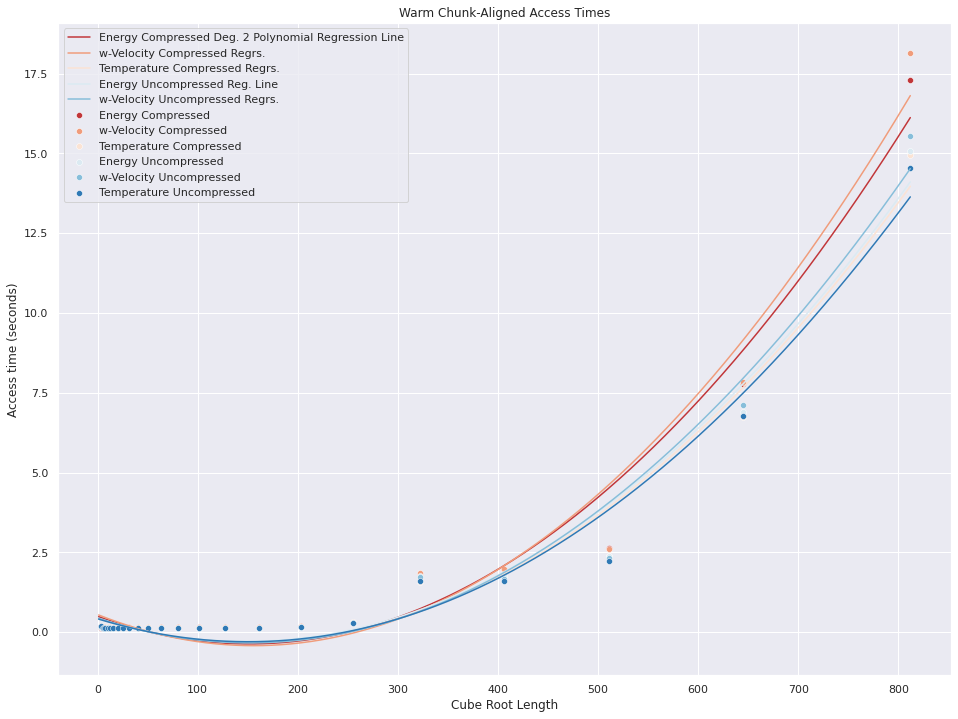

In [187]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})

# Energy compressed
var = np.mean(mcw_e_array, axis=1)# / 1000


# Diverging Palettes - https://www.codecademy.com/article/seaborn-design-ii
sns.set_palette("RdBu")

ax = sns.scatterplot(x=cube_root_size, y=var, label="Energy Compressed").set(xlabel='Cube Root Length', ylabel='Access time (seconds)')
#ax.set(xlabel='Cube Root Length', ylabel='Access time (ms)')

# https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot
mymodel = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline, mymodel(myline), label="Energy Compressed Deg. 2 Polynomial Regression Line")#, color="orange")

# w-velocity compressed
var = np.mean(mcw_w_array, axis=1)# / 1000

ax = sns.scatterplot(x=cube_root_size, y=var, label="w-Velocity Compressed")

mymodel_w = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_w = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_w, mymodel_w(myline_w), label="w-Velocity Compressed Regrs.")


# Temperature compressed
var = np.mean(mcw_t_array, axis=1)# / 1000

ax = sns.scatterplot(x=cube_root_size, y=var, label="Temperature Compressed")

mymodel_t = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_t = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_t, mymodel_t(myline_t), label="Temperature Compressed Regrs.")


# sns.set_palette("dark") # This has no effect for some reason


# Energy Uncompressed
var = np.mean(muw_e_array, axis=1)# / 1000
ax = sns.scatterplot(x=cube_root_size, y=var, label="Energy Uncompressed", palette=["red"])
#ax.set(xlabel='Cube Root Length', ylabel='Access time (ms)')

mymodel = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline, mymodel(myline), label="Energy Uncompressed Reg. Line")#, color="orange")

# w-velocity Uncompressed
var = np.mean(muw_w_array, axis=1)# / 1000
ax = sns.scatterplot(x=cube_root_size, y=var, label="w-Velocity Uncompressed", palette=['dark'])

mymodel_w = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_w = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_w, mymodel_w(myline_w), label="w-Velocity Uncompressed Regrs.")


# Temperature Uncompressed
var = np.mean(muw_t_array, axis=1)# / 1000
ax = sns.scatterplot(x=cube_root_size, y=var, label="Temperature Uncompressed")

mymodel_t = np.poly1d(np.polyfit(cube_root_size, var, 2))
myline_t = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline_t, mymodel_t(myline_t), label="Temperature Uncompressed Regrs.")


plt.title("Warm Chunk-Aligned Access Times")
plt.show()

### 2048 with confidence intervals Warm Cache

In [188]:
experiment_repeats = 7 # Timeit does 7 by default

In [189]:
mcw_e_array.T[:,0]

array([0.17751099, 0.13937727, 0.13407432, 0.13833014, 0.13281599,
       0.13260368, 0.13260189])

In [190]:
mcw_e_array.T[:,1]

array([0.13317934, 0.13014977, 0.12867617, 0.1255253 , 0.14261178,
       0.13363709, 0.13242687])

Text(0.5, 1.0, 'Energy Warm Access')

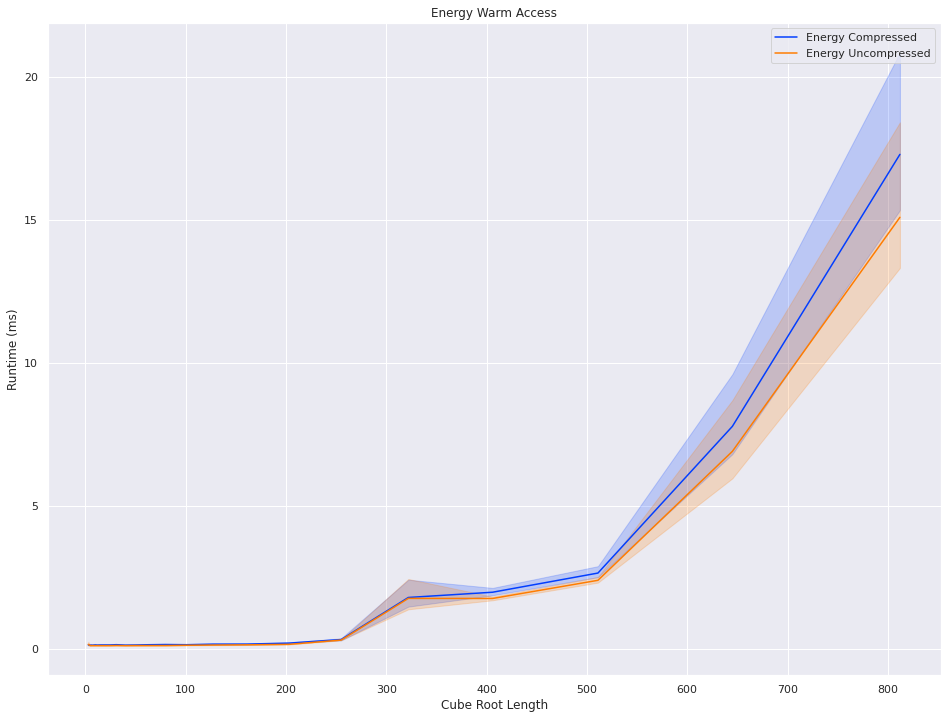

In [208]:
sns.set_palette("bright")

# compressed
var = mcw_e_array.T

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, experiment_repeats), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Energy Compressed");


# Uncompressed
var = muw_e_array.T

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, experiment_repeats), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Energy Uncompressed");


plt.title("Energy Warm Access")

Text(0.5, 1.0, 'w-Velocity Warm Access')

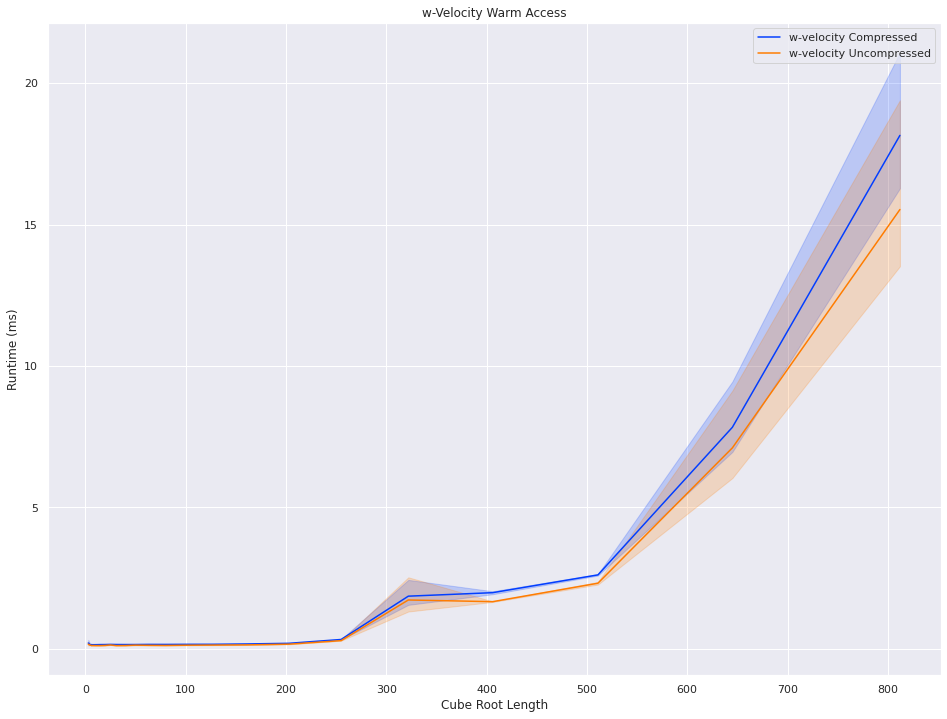

In [207]:
# w-Velocity

# compressed
var = mcw_w_array.T

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, experiment_repeats), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="w-velocity Compressed");


# Uncompressed
var = muw_w_array.T

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, experiment_repeats), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="w-velocity Uncompressed");

plt.title("w-Velocity Warm Access")

#### Temperature

Text(0.5, 1.0, 'Temperature Warm Access')

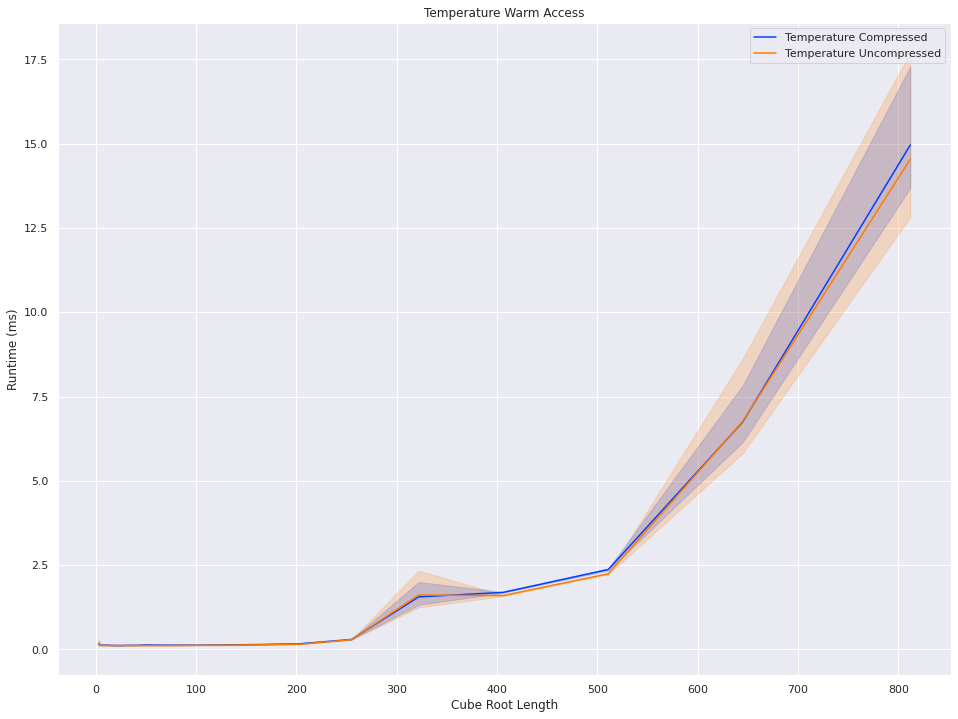

In [206]:
# compressed
var = mcw_t_array.T

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, experiment_repeats), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Temperature Compressed");


# Uncompressed
var = muw_t_array.T

a = pd.DataFrame(np.vstack((np.tile(cube_root_size, experiment_repeats), var.flatten()))).T
a = a.rename(columns={0: "Cube Root Length", 1: "Runtime (ms)"})

sns.lineplot( x = "Cube Root Length",
             y = "Runtime (ms)",
             data = a,
            label="Temperature Uncompressed");

plt.title("Temperature Warm Access")

#### Tabulate data

Array names

Warm
mcw_e_array mcw_w_array mcw_t_array muw_e_array muw_w_array muw_t_array

Cold
mcc_e mcc_t mcc_w mcu_e mcu_t mcu_w

In [250]:
uncomp_tab = [mcw_e_array, mcw_w_array, mcw_t_array, muw_e_array, muw_w_array, muw_t_array]
comp_tab = [mcc_e[:2], mcc_t[:2], mcc_w[:2], mcu_e[:2], mcu_t[:2], mcu_w[:2]]

In [257]:
mcc_e.T[:,0]

array([  201.,   311.,   335.,   435.,   114.,   387.,   332.,   454.,
         315.,   487.,   377.,   433.,   127.,   309.,   484.,   129.,
         388.,   422.,   415.,  1550.,  1650.,  5980.,  7370., 27600.])

In [260]:
pd.DataFrame([cube_root_size, mcc_e.T[:,0], mcc_e.T[:,1]]).T

,0,1,2
0,3.0,201.0,192.0
1,5.0,311.0,287.0
2,6.0,335.0,276.0
3,7.0,435.0,600.0
4,10.0,114.0,409.0
5,12.0,387.0,329.0
6,15.0,332.0,128.0
7,20.0,454.0,498.0
8,25.0,315.0,85.6
9,31.0,487.0,71.5
